In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from scipy.stats import randint, uniform
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.cluster import KMeans

En este script procesare los datos de la misma forma que el script V4 con la diferencia de
alguna transformacion externa de caracteristica. 
La prediccion la realizare con la tecniva voting classifier.

In [2]:
df_train = pd.read_csv('train.csv', index_col='id')
df_train

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
id,,,,,,,,,,,,,,,,,
0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20753,Male,25.137087,1.766626,114.187096,yes,yes,2.919584,3.000000,Sometimes,no,2.151809,no,1.330519,0.196680,Sometimes,Public_Transportation,Obesity_Type_II
20754,Male,18.000000,1.710000,50.000000,no,yes,3.000000,4.000000,Frequently,no,1.000000,no,2.000000,1.000000,Sometimes,Public_Transportation,Insufficient_Weight
20755,Male,20.101026,1.819557,105.580491,yes,yes,2.407817,3.000000,Sometimes,no,2.000000,no,1.158040,1.198439,no,Public_Transportation,Obesity_Type_II


In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20758 entries, 0 to 20757
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          20758 non-null  object 
 1   Age                             20758 non-null  float64
 2   Height                          20758 non-null  float64
 3   Weight                          20758 non-null  float64
 4   family_history_with_overweight  20758 non-null  object 
 5   FAVC                            20758 non-null  object 
 6   FCVC                            20758 non-null  float64
 7   NCP                             20758 non-null  float64
 8   CAEC                            20758 non-null  object 
 9   SMOKE                           20758 non-null  object 
 10  CH2O                            20758 non-null  float64
 11  SCC                             20758 non-null  object 
 12  FAF                             20758

In [3]:
# Castear variables float a enteras (teniendo en cuenta las fracciones de algunas caracteristicas)
def feature_float_int (df):
    df_copy = df.copy()
    columns_to_transform = ['Age', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']

    for i in columns_to_transform:
        if i == 'Age':                         
            df_copy[i]=df_copy[i].astype(int)
        else: df_copy[i]=round(df_copy[i]).astype(int)
        
    if any(df_copy[column].dtype !='int32' for column in columns_to_transform):
        print('Error: No se casteo correctamente alguna caracteristica')
        return df_copy
    
    print('Casteo realizado con exito')
    return df_copy

In [4]:
df_train = feature_float_int(df_train)
df_train.head()

Casteo realizado con exito


,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
id,,,,,,,,,,,,,,,,,
0,Male,24,1.699998,81.669950,yes,yes,2,3,Sometimes,no,3,no,0,1,Sometimes,Public_Transportation,Overweight_Level_II
1,Female,18,1.560000,57.000000,yes,yes,2,3,Frequently,no,2,no,1,1,no,Automobile,Normal_Weight
2,Female,18,1.711460,50.165754,yes,yes,2,1,Sometimes,no,2,no,1,2,no,Public_Transportation,Insufficient_Weight
3,Female,20,1.710730,131.274851,yes,yes,3,3,Sometimes,no,2,no,1,1,Sometimes,Public_Transportation,Obesity_Type_III
4,Male,31,1.914186,93.798055,yes,yes,3,2,Sometimes,no,2,no,2,1,Sometimes,Public_Transportation,Overweight_Level_II


In [5]:
# Eliminar valores atipicos de Age y Height

def delete_outliers (df):
    df_copy = df.copy()
    out=[]

    print('Tamaño del df antes de remover outliers:',df_copy.shape)
    columns_outliers = ['Age', 'Height']

    for i in columns_outliers:
        q1 = df_copy[i].quantile(0.25)
        q3 = df_copy[i].quantile(0.75)
        iqr = q3-q1
        Lower_tail = q1 - 2.5 * iqr
        Upper_tail = q3 + 2.5 * iqr
    
        outliers = df_copy[(df_copy[i] < Lower_tail) | (df_copy[i] > Upper_tail)]
        out.extend(outliers.index)

    out = list(set(out))
    df_copy = df_copy.drop(out)
    print("Outliers removidos. Tamaño del nuevo df:", df_copy.shape)
    return df_copy

In [6]:
df_train= delete_outliers (df_train)

Tamaño del df antes de remover outliers: (20758, 17)
Outliers removidos. Tamaño del nuevo df: (20576, 17)


In [7]:
# Funcion que redondea a dos decimales altura y peso
def round_weight_height(df):
    df_copy = df.copy()
    columns = ['Height', 'Weight']

    for i in columns:
        df_copy[i] = round(df_copy[i],2)
    print('redondeo de peso y altura realizado')
    return df_copy

In [8]:
df_train = round_weight_height(df_train)

redondeo de peso y altura realizado


In [9]:
# Funcion que calcula el IMC y la añade como variable nueva
def imc_calculator(df):
    df_copy = df.copy()
    
    df_copy['IMC'] = round(df_copy['Weight']/(df_copy['Height']**2),1)
    print('Calculo de IMC insertado en columna nueva y realizado correctamente')
    return df_copy

In [10]:
df_train=imc_calculator(df_train)

Calculo de IMC insertado en columna nueva y realizado correctamente


In [11]:
# Funcion que estratifica la edad en 5 categorias
def AgeBinning (df):
    df_copy = df.copy()

    bins = pd.qcut(df_copy['Age'],5, labels=False)
    bins[bins.isna()]=0

    df_copy['Qcut5_Age']=bins
    print('categorias de edades realizada con exito')
    return df_copy

In [12]:
df_train=AgeBinning(df_train)

categorias de edades realizada con exito


In [13]:
def activities_physical(df):
    df_copy = df.copy()

    df_copy['Activity_levels'] = (df_copy['FAF']-df_copy['TUE'])
    print('niveles de actividad realizados correctamente')
    return df_copy

In [14]:
df_train=activities_physical(df_train)

niveles de actividad realizados correctamente


In [15]:
def H2OBinning(df):
    df_copy = df.copy()

    bins = pd.qcut(df_copy['CH2O'],3, labels=False, duplicates='drop')
    bins[bins.isna()]=0

    df_copy['Qcut3_CH2O']=bins
    print('Niveles de agua realizados correctamente')
    return df_copy

In [16]:
df_train=H2OBinning(df_train)

Niveles de agua realizados correctamente


In [17]:
def NutritionHabits (df):
    df_copy = df.copy()

    df_copy['NutritionHabits'] = df_copy['CAEC']+'_'+df_copy['CALC']
    print('habitos de nutricion realizados correctamente')
    return df_copy

In [18]:
df_train=NutritionHabits(df_train)

habitos de nutricion realizados correctamente


In [19]:
df_train.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,...,FAF,TUE,CALC,MTRANS,NObeyesdad,IMC,Qcut5_Age,Activity_levels,Qcut3_CH2O,NutritionHabits
id,,,,,,,,,,,,,,,,,,,,,
0,Male,24,1.70,81.67,yes,yes,2,3,Sometimes,no,...,0,1,Sometimes,Public_Transportation,Overweight_Level_II,28.3,3,-1,1,Sometimes_Sometimes
1,Female,18,1.56,57.00,yes,yes,2,3,Frequently,no,...,1,1,no,Automobile,Normal_Weight,23.4,0,0,0,Frequently_no
2,Female,18,1.71,50.17,yes,yes,2,1,Sometimes,no,...,1,2,no,Public_Transportation,Insufficient_Weight,17.2,0,-1,0,Sometimes_no
3,Female,20,1.71,131.27,yes,yes,3,3,Sometimes,no,...,1,1,Sometimes,Public_Transportation,Obesity_Type_III,44.9,1,0,0,Sometimes_Sometimes
4,Male,31,1.91,93.80,yes,yes,3,2,Sometimes,no,...,2,1,Sometimes,Public_Transportation,Overweight_Level_II,25.7,4,1,0,Sometimes_Sometimes


In [20]:
# Movemos la variable objetivo al final de df
column_pop = df_train.pop('NObeyesdad')
df_train.insert(21, 'NObeyesdad', column_pop)

In [123]:
# Separamos en X e y
X = df_train.iloc[:, :-1]
y = df_train.iloc[:, 21]

In [22]:
# Codificar valores categoricos
def dummies_variable (X):
    X_copy = X.copy()
    categorical_var = X_copy.select_dtypes(include='object')

    # Creamos instancia de encoder
    encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    encoder.fit(categorical_var)
    # Codificamos
    categorical_encoded = encoder.transform(categorical_var)

    # Convertimos a df
    X_copy = pd.DataFrame(categorical_encoded, columns=encoder.get_feature_names_out(categorical_var.columns))
    print('Codificacion a dummies correctamente...')
    return X_copy

In [124]:
X_categorical = dummies_variable (X)

Codificacion a dummies correctamente...


In [24]:
# Normalizar los datos nuemericos
def normalizer_numerical (X):
    X_copy = X.copy()
    numerical_val = X_copy.select_dtypes(include='number')
    columns_name = numerical_val.columns
    # escalado y transformacion
    scaler = StandardScaler()
    nuemrical_scaled = scaler.fit_transform(numerical_val)

    # Convertimos a df
    numerical_df = pd.DataFrame(nuemrical_scaled, columns=columns_name)
    print('Normalizacion de variables numericas correcta')
    return numerical_df

In [125]:
X_numerical = normalizer_numerical (X)

Normalizacion de variables numericas correcta


In [26]:
# Funcion para concatenar categoricas y numericas
def concat_types(num,cat):
    X_ = pd.concat([num,cat], axis=1)
    print('Concatenacion realizada correctamente')
    return X_

In [126]:
X = concat_types(X_categorical,X_numerical)

Concatenacion realizada correctamente


In [28]:
X.head()

,Gender_Female,Gender_Male,family_history_with_overweight_no,family_history_with_overweight_yes,FAVC_no,FAVC_yes,CAEC_Always,CAEC_Frequently,CAEC_Sometimes,CAEC_no,...,Weight,FCVC,NCP,CH2O,FAF,TUE,IMC,Qcut5_Age,Activity_levels,Qcut3_CH2O
0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,-0.237268,-0.795737,0.324725,1.385153,-1.138737,0.565922,-0.233415,0.790880,-1.268699,1.679156
1,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,-1.169052,-0.795737,0.324725,-0.082453,0.014403,0.565922,-0.818547,-1.285130,-0.334852,-0.595537
2,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,-1.427021,-0.795737,-2.441389,-0.082453,0.014403,2.091059,-1.558917,-1.285130,-1.268699,-0.595537
3,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1.636120,0.969364,0.324725,-0.082453,0.014403,0.565922,1.748866,-0.593127,-0.334852,-0.595537
4,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.220881,0.969364,-1.058332,-0.082453,1.167543,0.565922,-0.543893,1.482884,0.598994,-0.595537


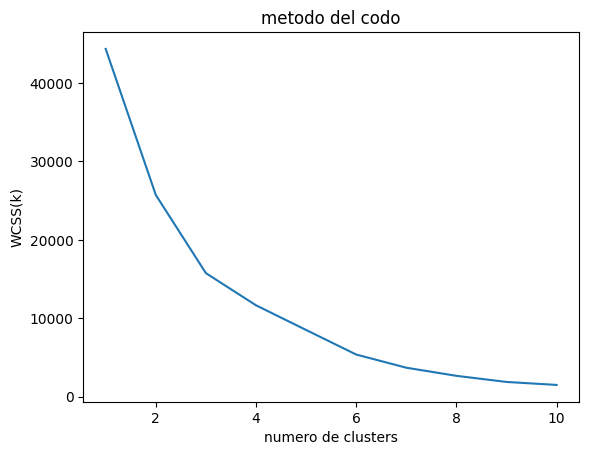

In [29]:
# Habitos de comida con Kmeans
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters= i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X[['FCVC','FAVC_yes','FAVC_no', 'CH2O']])
    #añadimos al final de wcss el sumatorio de los cuadrados de la distancia de k (inertia_)
    wcss.append(kmeans.inertia_)
    
plt.plot(range(1, 11), wcss)
plt.title('metodo del codo')
plt.xlabel('numero de clusters')
plt.ylabel('WCSS(k)')
plt.show()

In [30]:
def k_means(X):
    X_copy = X.copy()

    #Prediccion de clusters
    num_clusters = 6
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    pred_cluster = kmeans.fit_predict(X_copy[['FCVC','FAVC_yes','FAVC_no', 'CH2O']])

    # Convertimos la columna a dummies
    clusters_dummies = pd.get_dummies(pred_cluster, prefix='cluster', dtype='float64')
    X_copy = pd.concat([X_copy, clusters_dummies], axis=1)
    print('Clusteres calculados y representados con exito')
    return X_copy

In [127]:
X = k_means(X)

Clusteres calculados y representados con exito


In [122]:
# Elimino ciertas columnas cuya importancia no es considerable para XGBoost
def drop_features_(X):
        X.drop(['Gender_Male','family_history_with_overweight_yes',
                'FAVC_yes','SMOKE_yes','SCC_yes','NutritionHabits_no_Frequently',
                'Qcut5_Age','Qcut3_CH2O','NutritionHabits_Always_Frequently','MTRANS_Bike',
                'SMOKE_no','NutritionHabits_no_no'], axis =1, inplace=True)
        print('Eliminando algunas caracteristicas no entrenadas...')
        return X

In [128]:
X = drop_features_(X)

Eliminando algunas caracteristicas no entrenadas...


In [129]:
# Funcion global de procesamiento de datos (en conjuntos de prueba)
def processing_data(df):
    df = feature_float_int(df)
    df=round_weight_height(df)
    df=imc_calculator(df)
    df=AgeBinning(df)
    df=activities_physical(df)
    df=H2OBinning(df)
    df=NutritionHabits(df)
    df_dummies = dummies_variable (df)
    df_normalizer=normalizer_numerical (df)
    df_concat = concat_types(df_dummies,df_normalizer)
    df_concat = k_means(df_concat)
    df_concat = drop_features_(df_concat)
    print('=======================')
    print('Procesamiento de datos completado con exito')
    return df_concat

In [131]:
# Entrenar modelo y mostrar resultados entrenamiento y validacion
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=123, stratify=y)

In [36]:
# Creamos un diccionario para establecer los labels en la variable y (necesario en el algoritmo XGBoost)
label_mapping = {
    'Insufficient_Weight': 0,
    'Normal_Weight': 1,
    'Obesity_Type_I': 2,
    'Obesity_Type_II': 3,
    'Obesity_Type_III': 4,
    'Overweight_Level_I': 5,
    'Overweight_Level_II': 6
}

In [135]:
# Aplicar el mapeo a las etiquetas de entrenamiento
y_train_encoded = y_train.map(label_mapping)

# Aplicar el mapeo a las etiquetas de validacion
y_val_encoded = y_val.map(label_mapping)

In [38]:
# Algoritmo XGBoost
model = XGBClassifier(random_state=42 ,objective='multi:softmax')

In [136]:
# Entrenar el modelo
model.fit(X_train, y_train_encoded)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', ...)

In [137]:
# Obtener importancia de características
feature_importances = model.feature_importances_
# Nombres de caracteristicas
names_column = X_val.columns

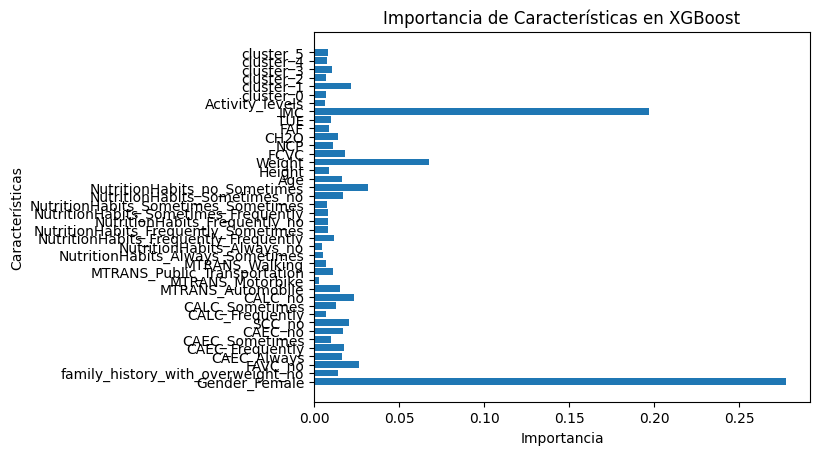

In [138]:
# Visualizar importancia de características con sus nombres
plt.barh(names_column, feature_importances)
plt.xlabel('Importancia')
plt.ylabel('Características')
plt.title('Importancia de Características en XGBoost')
plt.show()

Busqueda del modelo XGBoost con ajuste de hiperparametros automatico

In [139]:
# Definir la cuadrícula de hiperparámetros para la búsqueda aleatoria
param_dist = {
    'learning_rate': uniform(0, 1),
    'n_estimators': randint(500, 2000),
    'gamma':uniform(0,1),
    'reg_alpha':uniform(0,1),
    'reg_lambda':uniform(0,1),
    'min_child_weight':randint(0,10),
    'max_depth': randint(4, 10),
    'subsample': uniform(0, 1),
    'colsample_bytree': uniform(0, 1),
}

In [140]:
# Configurar la búsqueda aleatoria
random_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=10, 
                                   scoring='accuracy', cv=5, verbose=1, n_jobs=-1)

In [141]:
# Realizar la búsqueda aleatoria en los datos de entrenamiento
random_search.fit(X_train, y_train_encoded)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000022D33C7ADD0>,
                                        'reg_alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000022D40FC7F90>,
                                        'reg_lambda': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000022D41007A10>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000022D33C734D0>},
                   scoring='accuracy', verbose=1)

In [142]:
# Obtenemos lso hiperparametros buscados
best_params = random_search.best_params_

In [143]:
xgb_clf = XGBClassifier(**best_params)

Busqueda aleatoria hiperparamteros LGBM

In [144]:
model_lgbm = LGBMClassifier(random_state=123,verbose=-1)

In [145]:
# Definir la cuadrícula de hiperparámetros para la búsqueda aleatoria
lgbm_params = {
    'learning_rate': uniform(0, 1),
    'n_estimators': randint(2, 500),
    'reg_alpha':uniform(0,1),
    'reg_lambda':uniform(0,1),
    'min_child_samples':randint(0,10),
    'max_depth': randint(4, 10),
    'subsample': uniform(0, 1),
    'num_leaves':randint(10,50),
    'colsample_bytree': uniform(0, 1),
}

In [146]:
# Configurar la búsqueda aleatoria
lgbm_search = RandomizedSearchCV(model_lgbm, param_distributions=lgbm_params, n_iter=10,
                                 cv=5, n_jobs=-1)

In [147]:
# Realizar la búsqueda aleatoria en los datos de entrenamiento
lgbm_search.fit(X_train, y_train_encoded)

RandomizedSearchCV(cv=5, estimator=LGBMClassifier(random_state=123, verbose=-1),
                   n_jobs=-1,
                   param_distributions={'colsample_bytree': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000022D40F97550>,
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000022D40FF0F50>,
                                        'max_depth': <scipy.stats._distn_infrastr...
                                        'num_leaves': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000022D33C78C90>,
                                        'reg_alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000022D40FF2050>,
                                        'reg_lambda': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000022D3FE49110>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000022D3FE2D750>})

In [148]:
# Obtenemos lso hiperparametros buscados
best_params_lgbm = lgbm_search.best_params_

In [149]:
lgbm_clf = LGBMClassifier(**best_params_lgbm)

Busqueda aliatoria hiperparametros CatBoost

In [150]:
model_cat = CatBoostClassifier(random_state=123,logging_level='Silent')

In [151]:
catboost_params= {
    'iterations': randint(500, 1000),
    'depth': randint(2, 10), 
    'min_data_in_leaf': randint(1, 5), 
    'learning_rate': uniform(0, 1),
}

In [152]:
# Configurar la búsqueda aleatoria
cat_search = RandomizedSearchCV(model_cat, param_distributions=catboost_params, n_iter=10,
                                 cv=5, n_jobs=-1)

In [153]:
# Realizar la búsqueda aleatoria en los datos de entrenamiento
cat_search.fit(X_train, y_train_encoded)

RandomizedSearchCV(cv=5,
                   estimator=<catboost.core.CatBoostClassifier object at 0x0000022D40FF7A90>,
                   n_jobs=-1,
                   param_distributions={'depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000022D40F75710>,
                                        'iterations': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000022D40F75A90>,
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000022D40FF2210>,
                                        'min_data_in_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000022D34119990>})

In [154]:
# Obtenemos lso hiperparametros buscados
best_params_cb = cat_search.best_params_

In [155]:
cb_clf = CatBoostClassifier(**best_params_cb)

Hacemos uso de la tecnica Soft Voting

In [156]:
# Crear el Voting Classifier
voting_clf = VotingClassifier(estimators=[
    ('xgb', xgb_clf),
    ('lgb', lgbm_clf),
    ('cb', cb_clf)
], voting='soft', weights = [1,1,1])

In [ ]:
voting_clf.fit(X_train, y_train_encoded)

In [ ]:
# Validacion cruzada
scores = cross_val_score(voting_clf, X_train, y_train_encoded, cv=5) 
print("Precisión media de la validación cruzada:", "{:.2f}".format(scores.mean()))

Precisión media de la validación cruzada: 91%

In [162]:
# Funcion que da el valor categorico a cada clave del diccionario labels (necesario para volver a tener los valores como texto)
def label_to_text (pred, label_mapping):
    pred_copy = pred

    # Obtener las etiquetas originales en el mismo orden que los valores numéricos
    original_labels = [key for key, value in sorted(label_mapping.items(), key=lambda x: x[1])]

    # Mapear los valores numéricos a las etiquetas originales
    text_predictions = [original_labels[value] for value in pred_copy]
    return text_predictions

Predecir con el conjunto de prueba

In [163]:
df_prueba = pd.read_csv('test.csv')
df_prueba

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS
0,20758,Male,26.899886,1.848294,120.644178,yes,yes,2.938616,3.000000,Sometimes,no,2.825629,no,0.855400,0.000000,Sometimes,Public_Transportation
1,20759,Female,21.000000,1.600000,66.000000,yes,yes,2.000000,1.000000,Sometimes,no,3.000000,no,1.000000,0.000000,Sometimes,Public_Transportation
2,20760,Female,26.000000,1.643355,111.600553,yes,yes,3.000000,3.000000,Sometimes,no,2.621877,no,0.000000,0.250502,Sometimes,Public_Transportation
3,20761,Male,20.979254,1.553127,103.669116,yes,yes,2.000000,2.977909,Sometimes,no,2.786417,no,0.094851,0.000000,Sometimes,Public_Transportation
4,20762,Female,26.000000,1.627396,104.835346,yes,yes,3.000000,3.000000,Sometimes,no,2.653531,no,0.000000,0.741069,Sometimes,Public_Transportation
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13835,34593,Male,23.327836,1.721384,78.030383,yes,no,2.813234,3.000000,Sometimes,no,1.000000,no,0.807076,0.778632,Sometimes,Public_Transportation
13836,34594,Female,29.000000,1.590000,62.000000,no,yes,3.000000,3.000000,Sometimes,no,2.000000,no,0.000000,0.000000,Sometimes,Public_Transportation
13837,34595,Female,22.935612,1.585547,44.376637,no,yes,3.000000,2.273740,Frequently,no,2.000000,no,1.949840,1.000000,Sometimes,Public_Transportation
13838,34596,Male,21.000000,1.620000,53.000000,yes,yes,2.000000,3.000000,Sometimes,no,2.000000,no,3.000000,2.000000,no,Public_Transportation


In [164]:
# Guardamos id
id_ = df_prueba['id']

In [165]:
# Eliminamos id
df_prueba.drop('id', axis=1, inplace=True)

In [166]:
df_prueba = processing_data(df_prueba)

Casteo realizado con exito
redondeo de peso y altura realizado
Calculo de IMC insertado en columna nueva y realizado correctamente
categorias de edades realizada con exito
niveles de actividad realizados correctamente
Niveles de agua realizados correctamente
habitos de nutricion realizados correctamente
Codificacion a dummies correctamente...
Normalizacion de variables numericas correcta
Concatenacion realizada correctamente
Clusteres calculados y representados con exito
Eliminando algunas caracteristicas no entrenadas...
Procesamiento de datos completado con exito


In [167]:
df_prueba.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13840 entries, 0 to 13839
Data columns (total 43 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Gender_Female                          13840 non-null  float64
 1   family_history_with_overweight_no      13840 non-null  float64
 2   FAVC_no                                13840 non-null  float64
 3   CAEC_Always                            13840 non-null  float64
 4   CAEC_Frequently                        13840 non-null  float64
 5   CAEC_Sometimes                         13840 non-null  float64
 6   CAEC_no                                13840 non-null  float64
 7   SCC_no                                 13840 non-null  float64
 8   CALC_Always                            13840 non-null  float64
 9   CALC_Frequently                        13840 non-null  float64
 10  CALC_Sometimes                         13840 non-null  float64
 11  CA

In [ ]:
# Eliminamos la columna 'CALC_Always' debido a que no esta entrenada en el conjunto de entrenamiento.
df_prueba.drop(['CALC_Always','NutritionHabits_Frequently_Always','NutritionHabits_Always_Always'], axis=1, inplace=True)

In [170]:
# Prediccion del modelo entrenado en el de prueba
prediction_ = voting_clf.predict(df_prueba)

In [171]:
# Convertimos a texto cada valor, dado el diccionario creado anteriormente
prediction_text = label_to_text(prediction_, label_mapping)

In [172]:
# Creamos el dataset de envio con la estructura exigida
submission = {'id': id_, 'NObeyesdad':prediction_text}

In [173]:
submit_v5 = pd.DataFrame(submission)
submit_v5

,id,NObeyesdad
0,20758,Obesity_Type_II
1,20759,Overweight_Level_I
2,20760,Obesity_Type_III
3,20761,Obesity_Type_I
4,20762,Obesity_Type_III
...,...,...
13835,34593,Overweight_Level_II
13836,34594,Normal_Weight
13837,34595,Insufficient_Weight
13838,34596,Normal_Weight


In [174]:
#Guardamos
submit_v5.to_csv('submitV5.7.csv', index=False)